# Social Media Analysis Project
## Amazon.com
### Objective: Collect data from Amazon.com about several earpods models using web crawling techniques and analyse sentiment about each one

## Data Collection

### Load packages and do the initializations

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import ssl
from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium.webdriver.firefox.options import Options
import time

In [2]:
# Allow not verified SSL (Secure Socket Layer) certificates to be opened
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Get Firefox options (configurations)
options = Options()

# Add this argument to Options to hide Firefox (make it not visible)
# options.add_argument('--headless')
options.add_argument("--disable-blink-features")
options.add_argument("--disable-blink-features=AutomationControlled")

In [4]:
# Load the list of the earpods to read the content
EarpodsList = pd.read_excel("EarpodsList.xlsx", sheet_name="EarpodsList", index_col="Brand_Product", engine='openpyxl')


In [5]:
# Create an empty dataframe for the resuls
earpodsReviews = pd.DataFrame({'Brand Product': pd.Series([], dtype='string'),
                             'User': pd.Series([], dtype='string'),
                             'Rating': pd.Series([], dtype='float'),
                             'Text': pd.Series([], dtype='string'),
                             'User Location': pd.Series([], dtype = 'string'),
                             'Date': pd.Series([], dtype = 'string'),
                             'Helpful Count': pd.Series([], dtype = 'string')
                             })

### Functions to use in the Main Loop

In [6]:
# Open page and read HTML
def openPageReadHTML(url):

    # Open Firefox with Selenium
    #binary = FirefoxBinary('/Applications/Firefox.app/Contents/MacOS/firefox-bin')  # replace the Firexfox path with the one on your computer
    #browser = webdriver.Firefox(firefox_binary=binary, options=options)
    browser = webdriver.Firefox(options=options, executable_path = r'C:\Users\pedro\Documents\Data Science\geckodriver-v0.29.1-win64\geckodriver.exe')
    browser.get(url)

    # If there is a privacy pop-up, click the OK button
    privacy_button = browser.find_elements_by_id("_evidon-accept-button")
    if len(privacy_button)>0:
        browser.execute_script("arguments[0].click()", privacy_button[0])
        time.sleep(1) # Wait half a second

    # Try to move into first review and click the button 
    # Sometimes it takes some time to load the page
    clicked_button=False
    while not clicked_button:
        read_more_buttons = browser.find_elements_by_class_name("a-expander-prompt")
        if len(read_more_buttons) > 0:
            try: 
                browser.execute_script("arguments[0].scrollIntoView(true);", read_more_buttons[0])
                browser.execute_script("arguments[0].click()", read_more_buttons[0])
                time.sleep(4) # Wait half a second
                clicked_button=True
            except:
                # Wait for one second to retry
                time.sleep(1)
        else:
            # Wait for one second to retry
            time.sleep(1)

    # Read the content close de browser
    html_source = browser.page_source  
    browser.quit()

    # Transform the html into a BeautifulSoup object
    soupObj = BeautifulSoup(html_source) 

    return soupObj

In [7]:
# Process each page
def processPage(soupObj, productID, extractedDF):

    # Read reviews
    reviews = soupObj.find_all("div", {"id": "cm_cr-review_list"})

    # Get the list of reviews
    reviewsList = reviews[0].select("div[data-hook*=review]")

    # Loop thru each review
    for i in range(0,len(reviewsList)):
        
        # Get Rating
        rating1 = reviewsList[i].select("span[class*=a-icon-alt]")
        rating2 = rating1[0].text
        rating3 = rating2[0:3]
        reviewRating = float(rating3)

        # Get User
        user1 = reviews[0].select("span[class*=a-profile-name]")
        reviewUser = user1[i].get_text()

        # Get review text
        text1 = reviews[0].select("span[data-hook*=review-body]")
        reviewText = text1[i].get_text()
        
        # Get the user location        
        location1 = reviews[0].select("span[data-hook*=review-date]")
        location2 = location1[i].get_text()
        cutStart_location = location2.find('Reviewed in ')
        cutStartSum_location = len('Reviewed in ')
        cutEnd_location = location2.find(' on ')
        location3 = location2[cutStart_location+cutStartSum_location:cutEnd_location]
        
        # To delete 'the' from the location in cases like 'the United States' or 'the United Kingdom'
        location4 = location3.find('the ')
        
        if location4 >= 0:
            reviewLocation = location3[4:]
        else:
            reviewLocation = location3
        
        # Get review date
        date1 = reviews[0].select("span[data-hook*=review-date]")
        date2 = date1[i].get_text()
        cutStart_date = location2.find(' on ')
        cutStartSum_date = len(' on ')
        reviewDate = location2[cutEnd_location+cutStartSum_date:]

        # Update extracted reviews dataframe
        extractedDF = extractedDF.append({'Brand Product': productID,
                             'User': reviewUser,
                             'Rating': reviewRating,
                             'Text': reviewText,
                             'User Location': reviewLocation,
                             'Date': reviewDate
                             }, ignore_index=True)

    # Return the resulting dataframe
    return extractedDF

### Main loop

In [8]:
# Define the number of reviews to obtain per product per page. Later When correcting this to automate Next page button, this number has to be changed accordingly. 10 because Amazon website has 10 reviews per page.
reviewsToGet = 10

In [9]:
# Loop for all products
for index, row in EarpodsList.iterrows():

    # Present feedback on which product is being processed
    print("Processing product", index)

    # Reset counter per product
    reviewsExtracted = 0    

    # Loop until it extracts the pre-defined number of reviews
    while reviewsExtracted<reviewsToGet:

        # Define URL to use based on the number of reviews extracted so far
        urlToUse = row['URL']
        if reviewsExtracted>0:
            repText = "-Reviews-or"+str(reviewsExtracted)+"-"
            urlToUse = urlToUse.replace("-Reviews-",repText)

        # Open and read the web page content
        soup = openPageReadHTML(urlToUse)

        # Process web page
        earpodsReviews = processPage(soup, index, earpodsReviews)

        # Update counter
        reviewsExtracted = reviewsExtracted + 5

        # Present feedback on the number of extracted reviews
        print("Extracted ",reviewsExtracted,"/",reviewsToGet)

Processing product Apple_Airpods
Extracted  5 / 10
Extracted  10 / 10
Processing product Bose_Earbuds
Extracted  5 / 10
Extracted  10 / 10
Processing product Huawei_Freebuds3
Extracted  5 / 10
Extracted  10 / 10
Processing product Samsung_GalaxyBuds
Extracted  5 / 10
Extracted  10 / 10
Processing product Apple_Airpods
Extracted  5 / 10
Extracted  10 / 10
Processing product Apple_Airpods
Extracted  5 / 10
Extracted  10 / 10
Processing product Apple_Airpods
Extracted  5 / 10
Extracted  10 / 10
Processing product Apple_Airpods
Extracted  5 / 10
Extracted  10 / 10
Processing product Bose_Earbuds
Extracted  5 / 10
Extracted  10 / 10
Processing product Bose_Earbuds
Extracted  5 / 10
Extracted  10 / 10
Processing product Bose_Earbuds
Extracted  5 / 10
Extracted  10 / 10
Processing product Bose_Earbuds
Extracted  5 / 10
Extracted  10 / 10
Processing product Huawei_Freebuds3
Extracted  5 / 10
Extracted  10 / 10
Processing product Huawei_Freebuds3
Extracted  5 / 10
Extracted  10 / 10
Processing 

In [10]:
# Save the extracted reviews data frame to an Excel file
earpodsReviews.to_excel("ExtractedReviews.xlsx")

## Sentiment Analysis

In [11]:
# Load packages

import nltk 
import re
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
extractedReviews = pd.DataFrame(pd.read_excel(r"C:\Users\pedro\Documents\Universidade\Data Science for Marketing_PG\Social Media Analysis\Project\ExtractedReviews.xlsx"))

In [13]:
extractedReviews.rename(columns = {'Unnamed: 0': 'reviewID'}, inplace = True)

In [14]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    cleanedText = []
    for x in (rawText[:]): 
        
        # Remove HTML
        if removeHTML:
            procText = BeautifulSoup(x,'html.parser').get_text()

         # Remove punctuation and other special characters
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)

        # Remove numbers
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)

        # Remove line breaks
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')

        # Remove special characters
        if len(specialCharsToRemove)>0:
            procText = re.sub(specialCharsToRemove,' ',procText)

        # Normalize to lower case
        if convertToLower:
            procText = procText.lower() 

        # Replace multiple consecutive spaces with just one space
        if removeConsecutiveSpaces:
            procText = re.sub(' +', ' ', procText)

        # If there is a text, add it to the clean text         
        if procText != '':
            cleanedText.append(procText)
    return cleanedText

In [15]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [16]:
# Function to recreate text from words
def recreateText(words):
    text_new = []
    for w in (words[:]):
        temp_str = (' ').join(w)
        text_new.append(temp_str)
    return text_new

In [17]:
# Function to break texts into sentences
def tokenize_sentences(texts):
    sentences_new = []
    for s in (texts[:]):
        s_token = sent_tokenize(s)
        sentences_new.append(s_token)
    return sentences_new

In [18]:
# Function to remove stop words
def removeStopWords(texts, stop_words):
  procText = []
  for t in (texts[:]):
    cleaned_text = [w for w in t[:] if not w in stop_words]
    procText.append(cleaned_text)
  return procText

In [19]:
# Because a review can express multiple opinions, let's analyse opinions by sentence

# Break reviews' into a list of lists sentences
listOfSentences = tokenize_sentences(extractedReviews.Text)

In [20]:
# Create a dataframe with only the description
ppText = textPreProcess(extractedReviews.Text, charsToRemove='', removeLineBreaks=False, removeNumbers=False)
processedReviews =  pd.DataFrame(data=ppText, index=extractedReviews.index, columns=['PreProcessedText']) 

In [21]:
# Check first review
extractedReviews.Text[1]

'\n\n  With the new transparency mode, I can listen to music knowing that I will never be ran over by a car on the street again. Another W for Tim Cook and the boys\n\n'

In [22]:
# Sentences of first review
listOfSentences[1]

['\n\n  With the new transparency mode, I can listen to music knowing that I will never be ran over by a car on the street again.',
 'Another W for Tim Cook and the boys']

In [23]:
# Create DataFrame for sentences
sentences = pd.DataFrame(data=[item for elem in listOfSentences for item in elem], columns=['BaseText'])

In [24]:
sentences

BaseText
0     \n\n  Like iphone 11 Pro, Macbook Pro, Airpad ...
1     Only one version.Let's go through the differen...
2     Physical Appearance:Shorter Stem, but larger b...
3     Still uses lighting cable to charge, but it do...
4     In-ear, instead of on-earIf your ear has a sma...
...                                                 ...
3803  So if you are using these for working out and ...
3804  I have had two pairs of Galaxy Buds + die due ...
3805  Worse comes to worse there are actually 3rd pa...
3806  I am not sure if you will find any earbuds tha...
3807  Seems like you would need something to encompa...

[3808 rows x 1 columns]

In [25]:
# Add a column with the review ID
sentencesPerReview = []
for elem in listOfSentences:
  sentencesPerReview.append(len(elem))
sentences['User'] = np.repeat(extractedReviews['User'].values,sentencesPerReview)
sentences['Brand Product'] = np.repeat(extractedReviews['Brand Product'].values,sentencesPerReview)

In [26]:
# Preprocess text 
sentences['PreProcessedText'] = textPreProcess(sentences['BaseText'])

In [27]:
# Get words
sentences['Words'] =  tokenize_words(sentences['PreProcessedText'])

In [28]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
sentences['WordsCleaned'] = removeStopWords(sentences['Words'], stop_words)

In [29]:
# Recreate sentence without stopwords
sentences['ProcessedText'] = recreateText(sentences['WordsCleaned'])

In [30]:
# Create sentiment analysis object
analyser = SentimentIntensityAnalyzer()

In [31]:
# To test, let's evaluate first sentence of first review
# Scales:
#   compound: -1:most extreme negative, 1:most extreme positive
#     positive: compound >=0.05
#     neutral: -0.05<compound<0.05
#     negative: compound <= -0.05
#   pos, neu, neg: proportion of text that are positive, neutral or negative
score = analyser.polarity_scores(sentences['ProcessedText'][0])
print(sentences['ProcessedText'][0],score)

like iphone pro macbook pro airpad pro pro denotes higher end product compared airpods version highest end model wireless charging case * airpods pro $ msrp compared non wireless case version 's $ * airpods pro wireless charging case default {'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compound': 0.3612}


In [32]:
# Process sentiment for all sentences
all_scores = []
for t in (sentences['ProcessedText'][:]):
  score = analyser.polarity_scores(t)
  all_scores.append(score)
sentences['Sentiment'] = [c['compound'] for c in all_scores]

In [33]:
# Compute review's sentiment as the mean sentiment from its sentences
meanByReview = sentences.groupby('User')['Sentiment'].mean()

# Consider sentences with no result as neutral (0)
meanByReview = meanByReview.fillna(0)

# Add column Sentiment to reviews Dataframe
extractedReviews['Sentiment'] = meanByReview[extractedReviews['User']].values

In [34]:
# Assign a qualitative evaluation to the review
bins = pd.IntervalIndex.from_tuples([(-1.1, -0.05), (-0.05, 0.05), (0.05, 1)], closed='right')
x = pd.cut(extractedReviews['Sentiment'].to_list(), bins)
x.categories = ['Negative','Neutral','Positive']
extractedReviews['Polarity'] = x

In [35]:
# Analysis examples:
# Mean by product 
ex1 = extractedReviews.groupby('Brand Product')['Sentiment'].mean().to_frame()
ex1

Sentiment
Brand Product                
Apple_Airpods        0.164108
Bose_Earbuds         0.148046
Huawei_Freebuds3     0.239867
Samsung_GalaxyBuds   0.262086

In [36]:
# Analysis examples:
# Mean by product and rating
ex2 = extractedReviews[['Brand Product','Rating','Sentiment']].groupby(['Brand Product','Rating'], as_index=False).mean()
ex2

Brand Product  Rating  Sentiment
0        Apple_Airpods       1   0.028933
1        Apple_Airpods       2   0.129819
2        Apple_Airpods       3   0.166748
3        Apple_Airpods       4   0.260063
4        Apple_Airpods       5   0.351868
5         Bose_Earbuds       1   0.053325
6         Bose_Earbuds       2   0.106623
7         Bose_Earbuds       3   0.152694
8         Bose_Earbuds       4   0.293389
9         Bose_Earbuds       5   0.287925
10    Huawei_Freebuds3       1   0.145125
11    Huawei_Freebuds3       2   0.275857
12    Huawei_Freebuds3       3   0.183324
13    Huawei_Freebuds3       4   0.146561
14    Huawei_Freebuds3       5   0.290066
15  Samsung_GalaxyBuds       1   0.156668
16  Samsung_GalaxyBuds       2   0.063354
17  Samsung_GalaxyBuds       3   0.304971
18  Samsung_GalaxyBuds       4   0.259325
19  Samsung_GalaxyBuds       5   0.385411

In [37]:
sentences

BaseText     User  \
0     \n\n  Like iphone 11 Pro, Macbook Pro, Airpad ...  Vincent   
1     Only one version.Let's go through the differen...  Vincent   
2     Physical Appearance:Shorter Stem, but larger b...  Vincent   
3     Still uses lighting cable to charge, but it do...  Vincent   
4     In-ear, instead of on-earIf your ear has a sma...  Vincent   
...                                                 ...      ...   
3803  So if you are using these for working out and ...     Gene   
3804  I have had two pairs of Galaxy Buds + die due ...     Gene   
3805  Worse comes to worse there are actually 3rd pa...     Gene   
3806  I am not sure if you will find any earbuds tha...     Gene   
3807  Seems like you would need something to encompa...     Gene   

           Brand Product                                   PreProcessedText  \
0          Apple_Airpods  \n\n like iphone pro macbook pro airpad pro th...   
1          Apple_Airpods  only one version let's go through the differen...   
2          Apple_Airpods  physical appearance shorter stem but larger bu...   
3          Apple_Airpods  still uses lighting cable to charge but it doe...   
4          Apple_Airpods  in ear instead of on earif your ear has a smal...   
...                  ...                                                ...   
3803  Samsung_GalaxyBuds  so if you are using these for working out and ...   
3804  Samsung_GalaxyBuds  i have had two pairs of galaxy buds + die due ...   
3805  Samsung_GalaxyBuds  worse comes to worse there are actually rd par...   
3806  Samsung_GalaxyBuds  i am not sure if you will find any earbuds tha...   
3807  Samsung_GalaxyBuds  seems like you would need something to encompa...   

                                                  Words  \
0     [like, iphone, pro, macbook, pro, airpad, pro,...   
1     [only, one, version, let, 's, go, through, the...   
2     [physical, appearance, shorter, stem, but, lar...   
3     [still, uses, lighting, cable, to, charge, but...   
4     [in, ear, instead, of, on, earif, your, ear, h...   
...                                                 ...   
3803  [so, if, you, are, using, these, for, working,...   
3804  [i, have, had, two, pairs, of, galaxy, buds, +...   
3805  [worse, comes, to, worse, there, are, actually...   
3806  [i, am, not, sure, if, you, will, find, any, e...   
3807  [seems, like, you, would, need, something, to,...   

                                           WordsCleaned  \
0     [like, iphone, pro, macbook, pro, airpad, pro,...   
1              [one, version, let, 's, go, differences]   
2     [physical, appearance, shorter, stem, larger, ...   
3     [still, uses, lighting, cable, charge, come, l...   
4     [ear, instead, earif, ear, small, cavum, origi...   
...                                                 ...   
3803  [using, working, want, samsung, buds, option, ...   
3804  [two, pairs, galaxy, buds, +, die, due, sweat,...   
3805  [worse, comes, worse, actually, rd, party, ret...   
3806         [sure, find, earbuds, n't, suffer, though]   
3807  [seems, like, would, need, something, encompas...   

                                          ProcessedText  Sentiment  
0     like iphone pro macbook pro airpad pro pro den...     0.3612  
1                     one version let 's go differences     0.0000  
2     physical appearance shorter stem larger bud he...     0.0000  
3     still uses lighting cable charge come lighting...     0.0000  
4     ear instead earif ear small cavum original air...     0.9517  
...                                                 ...        ...  
3803  using working want samsung buds option pro 's ...     0.0772  
3804  two pairs galaxy buds + die due sweat form fac...     0.5423  
3805  worse comes worse actually rd party retailers ...     0.7191  
3806                sure find earbuds n't suffer though     0.6310  
3807  seems like would need something encompass ears...     0.8687  

[3808 rows x 8 columns]

## N-Grams Analysis per product

#### ADICIONAR WORDCLOUDS A CADA 2-GRAM OU 3-GRAM

In [38]:
sentences_AppleAirpods = sentences[sentences['Brand Product'] == 'Apple_Airpods']
sentences_BoseEarbuds = sentences[sentences['Brand Product'] == 'Bose_Earbuds']
sentences_HuaweiFreebuds3 = sentences[sentences['Brand Product'] == 'Huawei_Freebuds3']
sentences_SamsungGalaxyBuds = sentences[sentences['Brand Product'] == 'Samsung_GalaxyBuds']

In [39]:
# Stemm texts
def stemming(words):
    procText = []
    for w in (words[:]):
        stemmed_word = [snowball.stem(x) for x in (w[:])]
        procText.append(stemmed_word)
    return procText

In [40]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### N-Grams for Apple Airpods

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

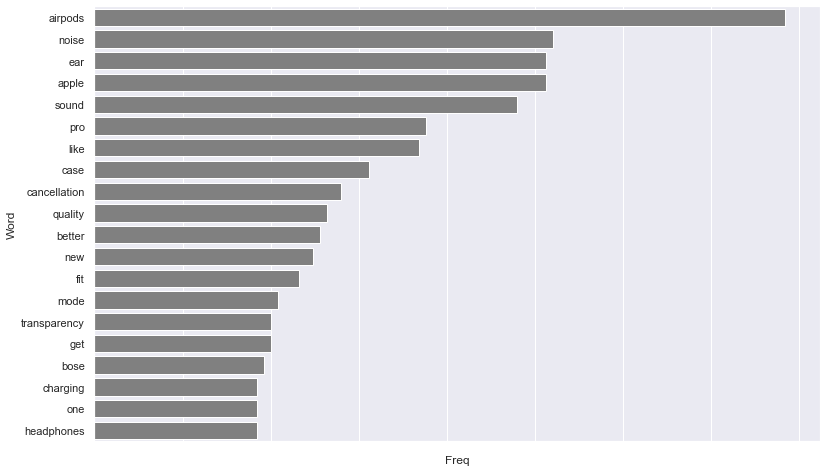

In [41]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words_Apple_1N = get_top_n_words(sentences_AppleAirpods['PreProcessedText'], n=20, nGrams=1)
top_words_Apple_1N = pd.DataFrame(top_words_Apple_1N)
top_words_Apple_1N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Apple_1N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

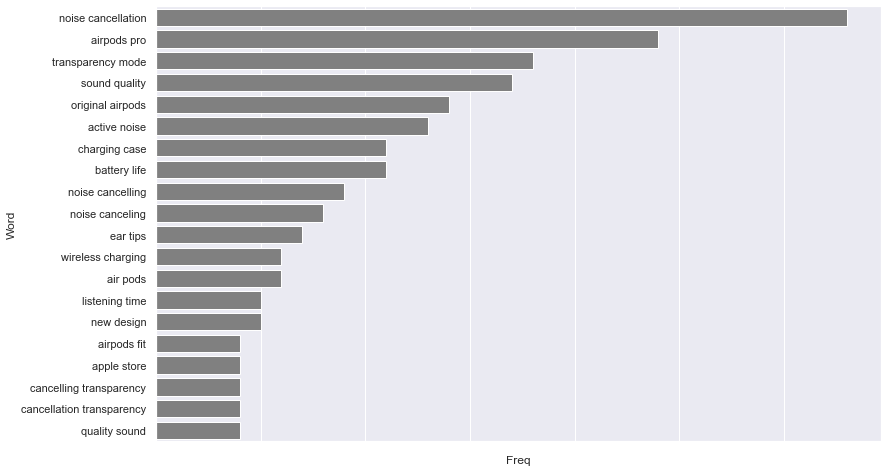

In [42]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words_Apple_2N = get_top_n_words(sentences_AppleAirpods['PreProcessedText'], n=20, nGrams=2)
top_words_Apple_2N = pd.DataFrame(top_words_Apple_2N)
top_words_Apple_2N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Apple_2N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

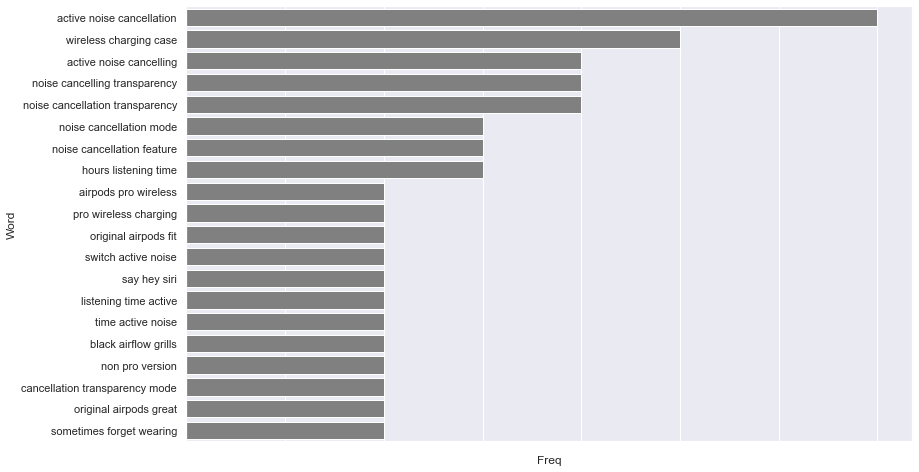

In [43]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words_Apple_3N = get_top_n_words(sentences_AppleAirpods['PreProcessedText'], n=20, nGrams=3)
top_words_Apple_3N = pd.DataFrame(top_words_Apple_3N)
top_words_Apple_3N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Apple_3N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

### N-Grams for Bose Earbuds

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

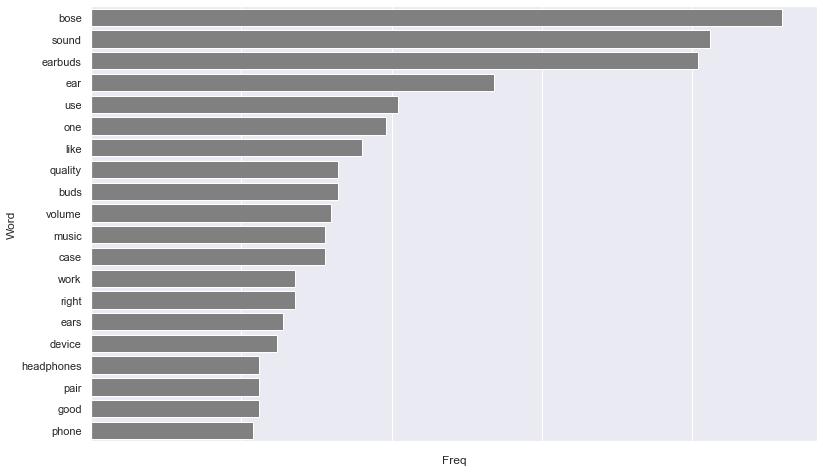

In [44]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words_Bose_1N = get_top_n_words(sentences_BoseEarbuds['PreProcessedText'], n=20, nGrams=1)
top_words_Bose_1N = pd.DataFrame(top_words_Bose_1N)
top_words_Bose_1N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Bose_1N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

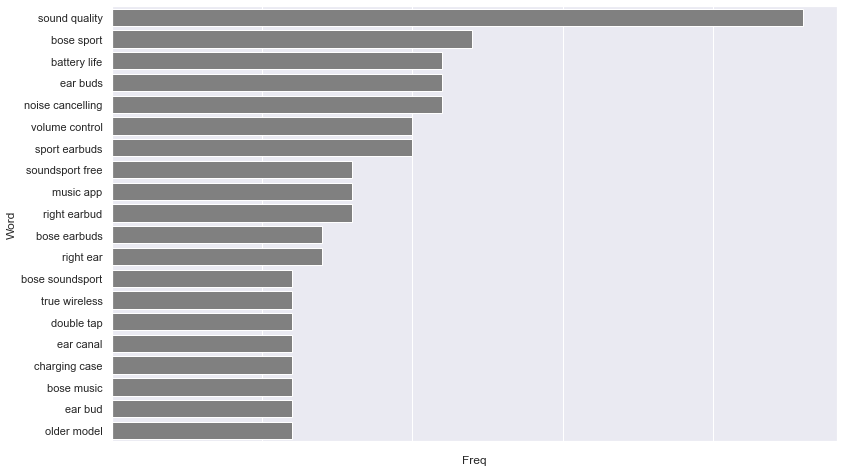

In [45]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words_Bose_2N = get_top_n_words(sentences_BoseEarbuds['PreProcessedText'], n=20, nGrams=2)
top_words_Bose_2N = pd.DataFrame(top_words_Bose_2N)
top_words_Bose_2N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Bose_2N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

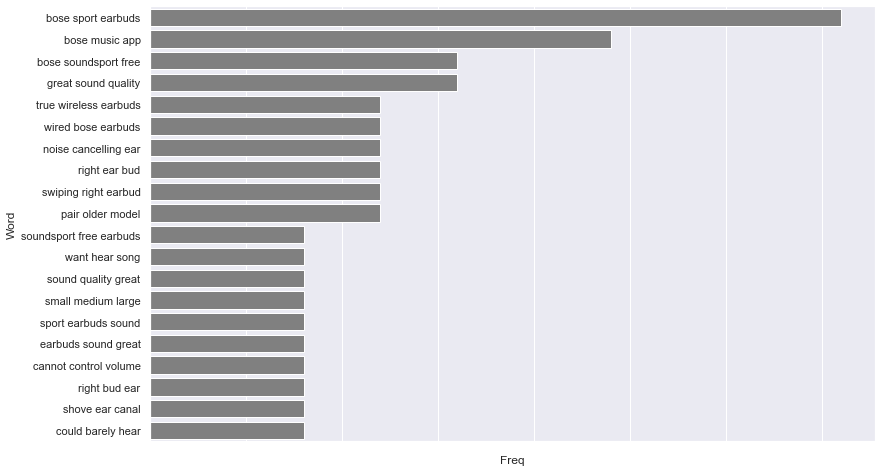

In [46]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words_Bose_3N = get_top_n_words(sentences_BoseEarbuds['PreProcessedText'], n=20, nGrams=3)
top_words_Bose_3N = pd.DataFrame(top_words_Bose_3N)
top_words_Bose_3N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Bose_3N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

### N-Grams for Huawei Freebuds 3

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

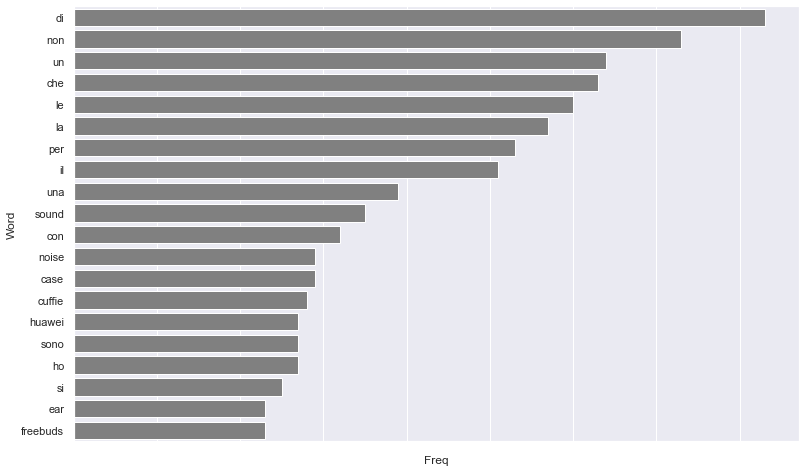

In [47]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words_Huawei_1N = get_top_n_words(sentences_HuaweiFreebuds3['PreProcessedText'], n=20, nGrams=1)
top_words_Huawei_1N = pd.DataFrame(top_words_Huawei_1N)
top_words_Huawei_1N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Huawei_1N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

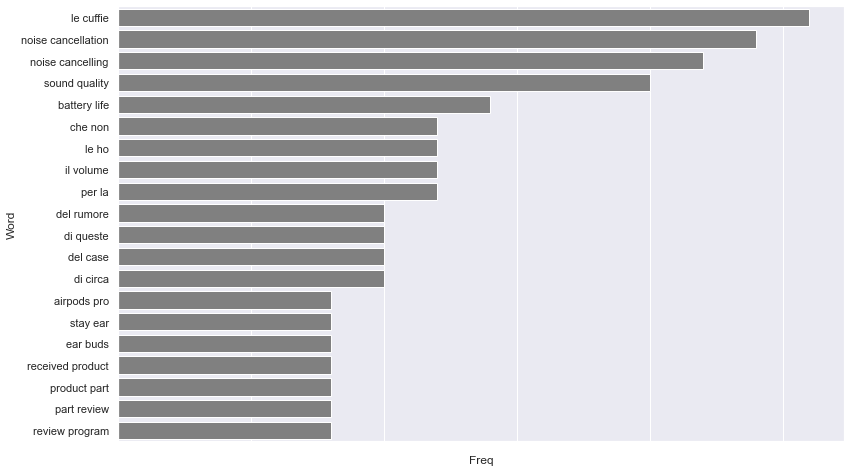

In [48]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words_Huawei_2N = get_top_n_words(sentences_HuaweiFreebuds3['PreProcessedText'], n=20, nGrams=2)
top_words_Huawei_2N = pd.DataFrame(top_words_Huawei_2N)
top_words_Huawei_2N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Huawei_2N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

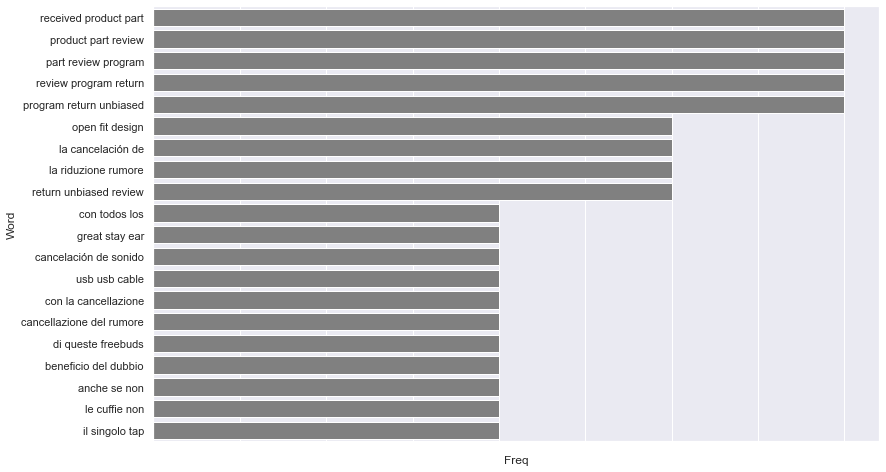

In [49]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words_Huawei_3N = get_top_n_words(sentences_HuaweiFreebuds3['PreProcessedText'], n=20, nGrams=3)
top_words_Huawei_3N = pd.DataFrame(top_words_Huawei_3N)
top_words_Huawei_3N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Huawei_3N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

### N-Grams for Samsung Galaxy Buds

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

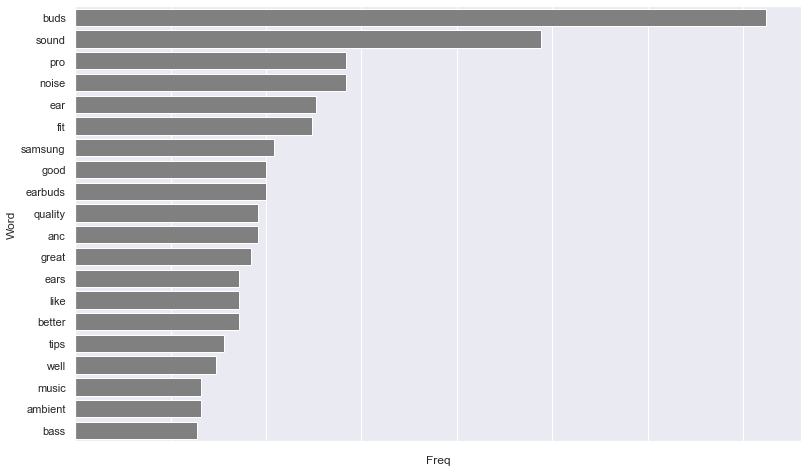

In [50]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words_Samsung_1N = get_top_n_words(sentences_SamsungGalaxyBuds['PreProcessedText'], n=20, nGrams=1)
top_words_Samsung_1N = pd.DataFrame(top_words_Samsung_1N)
top_words_Samsung_1N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Samsung_1N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

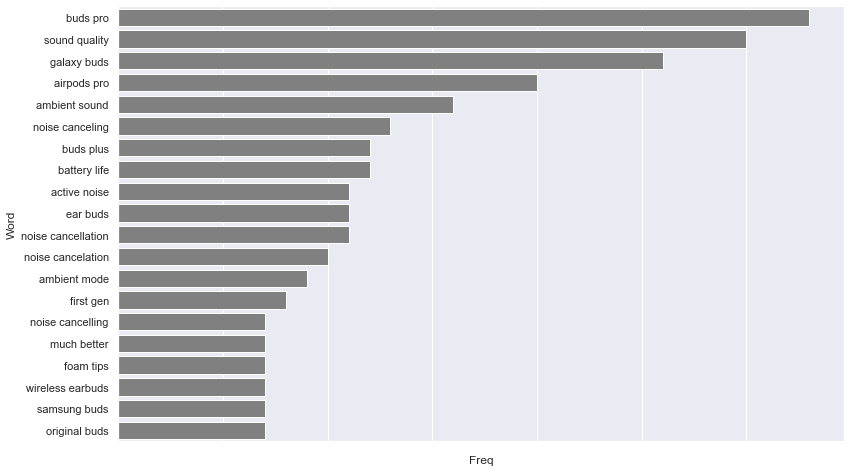

In [51]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words_Samsung_2N = get_top_n_words(sentences_SamsungGalaxyBuds['PreProcessedText'], n=20, nGrams=2)
top_words_Samsung_2N = pd.DataFrame(top_words_Samsung_2N)
top_words_Samsung_2N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Samsung_2N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

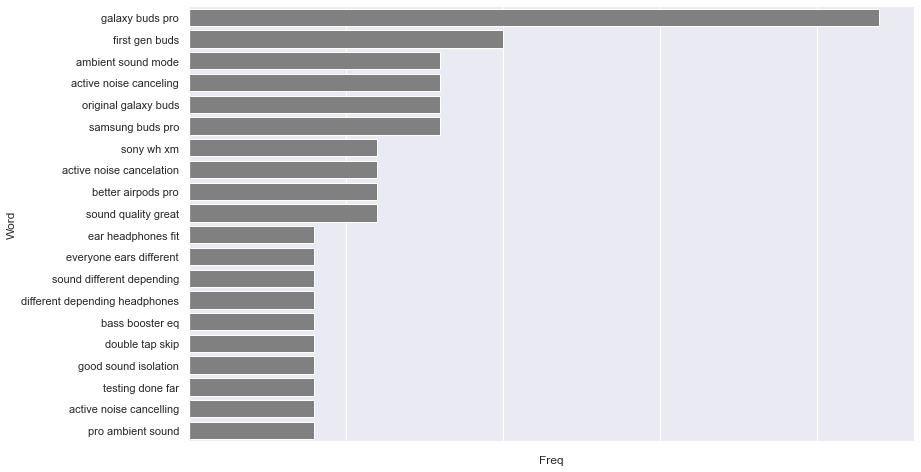

In [52]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words_Samsung_3N = get_top_n_words(sentences_SamsungGalaxyBuds['PreProcessedText'], n=20, nGrams=3)
top_words_Samsung_3N = pd.DataFrame(top_words_Samsung_3N)
top_words_Samsung_3N.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_words_Samsung_3N, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

## WordCloud

In [53]:
# Load libraries
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [54]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [55]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [56]:
processedReviews['Words'] =  tokenize_words(processedReviews['PreProcessedText'])

In [57]:
processedReviews

PreProcessedText  \
0    \n\n like iphone 11 pro, macbook pro, airpad p...   
1    \n\n with the new transparency mode, i can lis...   
2                                   \n\n they fire\n\n   
3    \n\n love apple products but i m tired of thei...   
4    \n\n these earphones are top of the line.here ...   
..                                                 ...   
395  \n\n so these are very very good earbuds. i gu...   
396  \n\n i love these headphones, but they don't s...   
397  \n\n sound quality is great, but.....there is ...   
398  \n\n what an amazing set of earbuds, these are...   
399  \n\n i am returning the ones i have received t...   

                                                 Words  
0    [like, iphone, 11, pro, ,, macbook, pro, ,, ai...  
1    [with, the, new, transparency, mode, ,, i, can...  
2                                         [they, fire]  
3    [love, apple, products, but, i, m, tired, of, ...  
4    [these, earphones, are, top, of, the, line.her...  
..                                                 ...  
395  [so, these, are, very, very, good, earbuds, .,...  
396  [i, love, these, headphones, ,, but, they, do,...  
397  [sound, quality, is, great, ,, but, ....., the...  
398  [what, an, amazing, set, of, earbuds, ,, these...  
399  [i, am, returning, the, ones, i, have, receive...  

[400 rows x 2 columns]

In [58]:
sentences_AppleAirpods = sentences[sentences['Brand Product'] == 'Apple_Airpods']
sentences_BoseEarbuds = sentences[sentences['Brand Product'] == 'Bose_Earbuds']
sentences_HuaweiFreebuds3 = sentences[sentences['Brand Product'] == 'Huawei_Freebuds3']
sentences_SamsungGalaxyBuds = sentences[sentences['Brand Product'] == 'Samsung_GalaxyBuds']

### Apple WordCloud

In [59]:
# Compute terms frequency distribution
fdist1 = FreqDist()
for review in sentences_AppleAirpods.Words:
  for term in review:
    fdist1[term]+=1

In [60]:
# Transform results to a sorted dataframe
termFrequency_Apple = pd.DataFrame.from_dict(fdist1, orient='index')
termFrequency_Apple.columns = ['Frequency']
termFrequency_Apple.index.name = 'Term'
termFrequency_Apple = termFrequency_Apple.sort_values(by='Frequency', ascending=False)

In [61]:
# Remove stopwords and re-explore results
stop_words = set(stopwords.words('english'))
termFrequency_Apple = termFrequency_Apple[~termFrequency_Apple.index.isin(stop_words)]
termFrequency_Apple.head(15)

# 1-Gram don't seem appropriate for Word Cloud conclusions. I will work with 2-Gram

Frequency
Term                   
airpods             194
noise               130
ear                 128
apple               128
sound               120
pro                  94
like                 92
case                 78
cancellation         70
better               64
quality              64
new                  62
's                   62
fit                  56
mode                 52

In [62]:
# Set Word as index and sort by Frequency
top_words_Apple_2N.set_index('Word', inplace = True)
top_words_Apple_2N = top_words_Apple_2N.sort_values(by='Freq', ascending=False)

# Remove the stopwords
Apple_2N_Frequency = top_words_Apple_2N[~top_words_Apple_2N.index.isin(stop_words)]

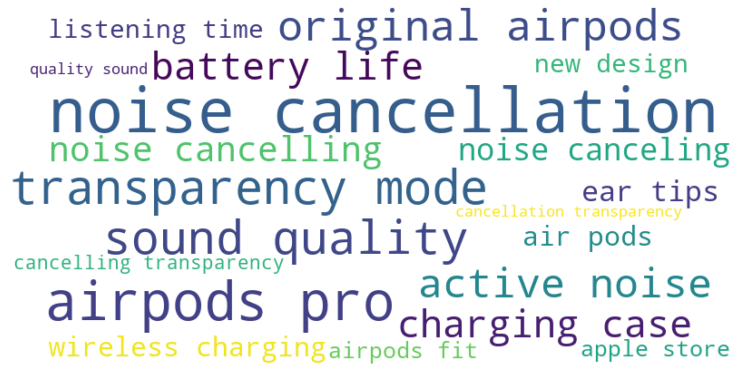

In [63]:
# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=Apple_2N_Frequency.Freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [64]:
termFrequency_Apple

Frequency
Term                   
airpods             194
noise               130
ear                 128
apple               128
sound               120
...                 ...
windows               2
conveniently          2
tired                 2
lying                 2
happy                 2

[1494 rows x 1 columns]

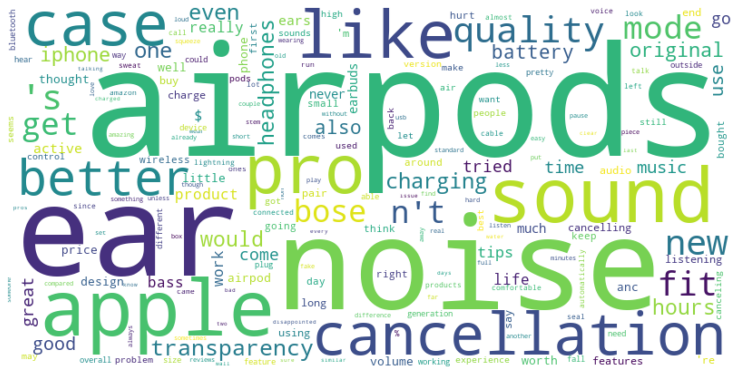

In [65]:
# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=termFrequency_Apple.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Bose WordCloud

In [66]:
# Compute terms frequency distribution
fdist2 = FreqDist()
for review in sentences_BoseEarbuds.Words:
  for term in review:
    fdist2[term]+=1

In [67]:
# Transform results to a sorted dataframe
termFrequency_Bose = pd.DataFrame.from_dict(fdist2, orient='index')
termFrequency_Bose.columns = ['Frequency']
termFrequency_Bose.index.name = 'Term'
termFrequency_Bose = termFrequency_Bose.sort_values(by='Frequency', ascending=False)

In [68]:
# Remove stopwords and re-explore results
stop_words = set(stopwords.words('english'))
termFrequency_Bose = termFrequency_Bose[~termFrequency_Bose.index.isin(stop_words)]
termFrequency_Bose.head(30)

Frequency
Term                 
bose              230
sound             204
earbuds           202
n't               146
ear               134
use               102
one                98
like               90
buds               82
volume             80
quality            80
case               78
music              78
work               68
ears               64
right              64
device             62
's                 58
good               56
headphones         56
pair               56
phone              54
well               52
great              52
get                50
control            50
fit                50
time               50
want               48
even               48

In [69]:
# Set Word as index and sort by Frequency
top_words_Bose_2N.set_index('Word', inplace = True)
top_words_Bose_2N = top_words_Bose_2N.sort_values(by='Freq', ascending=False)

# Remove the stopwords
Bose_2N_Frequency = top_words_Bose_2N[~top_words_Bose_2N.index.isin(stop_words)]

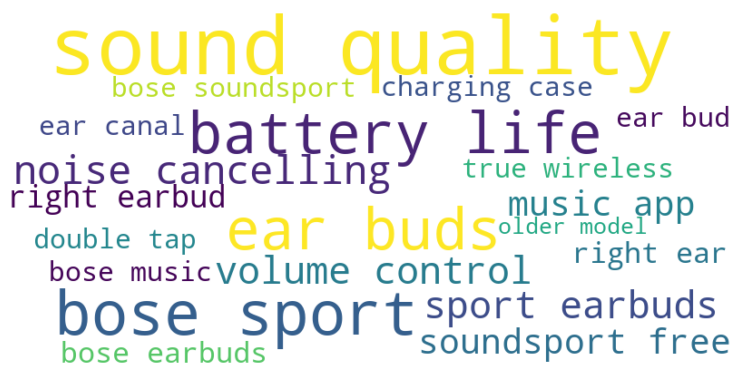

In [70]:
# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=Bose_2N_Frequency.Freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Huawei WordCloud

In [71]:
# Compute terms frequency distribution
fdist3 = FreqDist()
for review in sentences_HuaweiFreebuds3.Words:
  for term in review:
    fdist3[term]+=1

In [72]:
# Transform results to a sorted dataframe
termFrequency_Huawei = pd.DataFrame.from_dict(fdist3, orient='index')
termFrequency_Huawei.columns = ['Frequency']
termFrequency_Huawei.index.name = 'Term'
termFrequency_Huawei = termFrequency_Huawei.sort_values(by='Frequency', ascending=False)

In [73]:
# Remove stopwords and re-explore results
stop_words = set(stopwords.words('english'))
termFrequency_Huawei = termFrequency_Huawei[~termFrequency_Huawei.index.isin(stop_words)]
termFrequency_Huawei.head(15)

Frequency
Term            
di           166
e            160
non          146
che          126
le           120
un           120
la           114
per          106
il           102
è             84
una           78
sound         70
con           64
noise         58
case          58

In [74]:
# Set Word as index and sort by Frequency
top_words_Huawei_2N.set_index('Word', inplace = True)
top_words_Huawei_2N = top_words_Huawei_2N.sort_values(by='Freq', ascending=False)

# Remove the stopwords
Huawei_2N_Frequency = top_words_Huawei_2N[~top_words_Huawei_2N.index.isin(stop_words)]

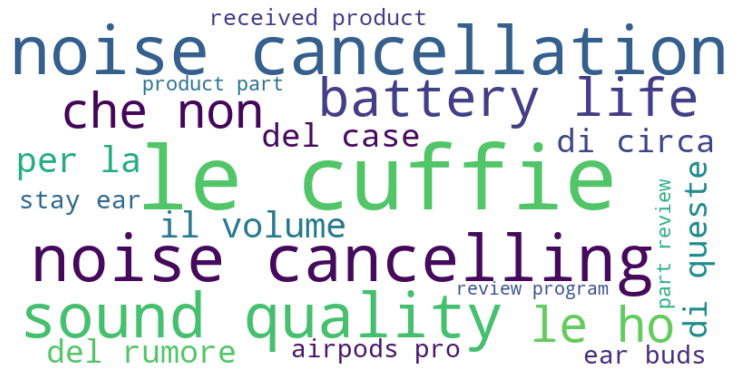

In [75]:
# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=Huawei_2N_Frequency.Freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Samsung WordCloud

In [76]:
# Compute terms frequency distribution
fdist4 = FreqDist()
for review in sentences_SamsungGalaxyBuds.Words:
  for term in review:
    fdist4[term]+=1

In [77]:
# Transform results to a sorted dataframe
termFrequency_Samsung = pd.DataFrame.from_dict(fdist4, orient='index')
termFrequency_Samsung.columns = ['Frequency']
termFrequency_Samsung.index.name = 'Term'
termFrequency_Samsung = termFrequency_Samsung.sort_values(by='Frequency', ascending=False)

In [78]:
# Remove stopwords and re-explore results
stop_words = set(stopwords.words('english'))
termFrequency_Samsung = termFrequency_Samsung[~termFrequency_Samsung.index.isin(stop_words)]
termFrequency_Samsung.head(15)

Frequency
Term              
buds           350
sound          244
n't            186
noise          142
pro            140
ear            126
fit            124
's             118
samsung        104
good           100
earbuds        100
quality         96
anc             94
great           92
like            86

In [79]:
# Set Word as index and sort by Frequency
top_words_Samsung_2N.set_index('Word', inplace = True)
top_words_Samsung_2N = top_words_Samsung_2N.sort_values(by='Freq', ascending=False)

# Remove the stopwords
Samsung_2N_Frequency = top_words_Samsung_2N[~top_words_Samsung_2N.index.isin(stop_words)]

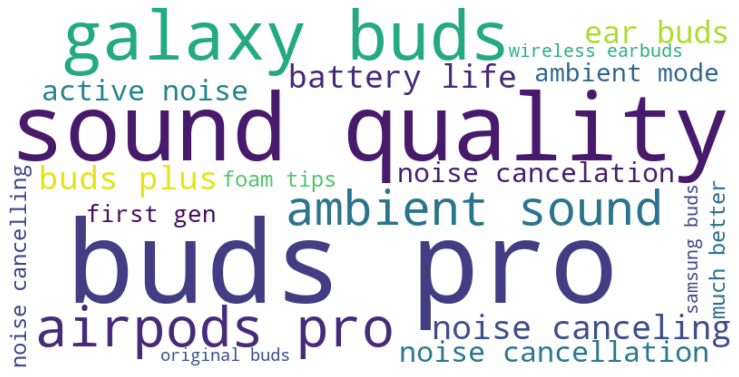

In [80]:
# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=Samsung_2N_Frequency.Freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Chord Diagram

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
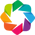

Error: Value 'svg' for key 'fig' not one of ['html', 'auto', 'png']
For help with hv.util.output call help(hv.util.output)


In [81]:
# Load Libraries
import holoviews as hv
from holoviews import opts, dim
hv.extension("bokeh")
#hv.extension("matplotlib")
hv.output(fig='svg', size=250)

In [82]:
sentencesList_AppleAirpods = sentences_AppleAirpods['PreProcessedText'].to_list()
text_Apple = sentencesList_AppleAirpods

sentencesList_BoseEarbuds = sentences_BoseEarbuds['PreProcessedText'].to_list()
text_Bose = sentencesList_BoseEarbuds

sentencesList_HuaweiFreebuds = sentences_HuaweiFreebuds3['PreProcessedText'].to_list()

sentencesList_SamsungGalaxyBuds = sentences_SamsungGalaxyBuds['PreProcessedText'].to_list()

In [83]:
# Create the top 1-grams co-occurrence matrix for further input for the chord diagram
# Retrieved from: https://stackoverflow.com/questions/35562789/how-do-i-calculate-a-word-word-co-occurrence-matrix-with-sklearn

# Load Libraries
from collections import defaultdict

def co_occurrence(sentences, window_size):
    d = defaultdict(int)
    vocab = set()
    for text in sentences:
        # preprocessing (use tokenizer instead)
        text = text.lower().split()
        # iterate over sentences
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)  # add to vocab
            next_token = text[i+1 : i+1+window_size]
            for t in next_token:
                key = tuple( sorted([t, token]) )
                d[key] += 1
    
    # formulate the dictionary into dataframe
    vocab = sorted(vocab) # sort vocab
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

In [84]:
top_words_Apple_1N_List = top_words_Apple_1N['Word'].tolist()
top_words_Apple_1N_array = np.array(top_words_Apple_1N_List)
top_words_Apple_1N_terms = pd.DataFrame(top_words_Apple_1N, columns = ['Word'])

top_words_Bose_1N_List = top_words_Bose_1N['Word'].tolist()
top_words_Bose_1N_array = np.array(top_words_Bose_1N_List)
top_words_Bose_1N_terms = pd.DataFrame(top_words_Bose_1N, columns = ['Word'])

top_words_Huawei_1N_List = top_words_Huawei_1N['Word'].tolist()
top_words_Huawei_1N_array = np.array(top_words_Huawei_1N_List)
top_words_Huawei_1N_terms = pd.DataFrame(top_words_Huawei_1N, columns = ['Word'])

top_words_Samsung_1N_List = top_words_Samsung_1N['Word'].tolist()
top_words_Samsung_1N_array = np.array(top_words_Samsung_1N_List)
top_words_Samsung_1N_terms = pd.DataFrame(top_words_Samsung_1N, columns = ['Word'])

In [86]:
coOccurrence_AppleAirpods = co_occurrence(sentencesList_AppleAirpods, 2)
coOccurrence_AppleAirpods2 = coOccurrence_AppleAirpods[top_words_Apple_1N_List]
coOccurrence_AppleAirpods2 = coOccurrence_AppleAirpods2.loc[top_words_Apple_1N_List]

coOccurrence_BoseEarbuds = co_occurrence(sentencesList_BoseEarbuds, 2)
coOccurrence_BoseEarbuds2 = coOccurrence_BoseEarbuds[top_words_Bose_1N_List]
coOccurrence_BoseEarbuds2 = coOccurrence_BoseEarbuds2.loc[top_words_Bose_1N_List]

coOccurrence_HuaweiFreebuds = co_occurrence(sentencesList_HuaweiFreebuds, 2)
coOccurrence_HuaweiFreebuds2 = coOccurrence_HuaweiFreebuds[top_words_Huawei_1N_List]
coOccurrence_HuaweiFreebuds2 = coOccurrence_HuaweiFreebuds2.loc[top_words_Huawei_1N_List]

coOccurrence_SamsungGalaxyBuds = co_occurrence(sentencesList_SamsungGalaxyBuds, 2)
coOccurrence_SamsungGalaxyBuds2 = coOccurrence_SamsungGalaxyBuds[top_words_Samsung_1N_List]
coOccurrence_SamsungGalaxyBuds2 = coOccurrence_SamsungGalaxyBuds2.loc[top_words_Samsung_1N_List]

In [87]:
# Retrieved from: https://stackoverflow.com/questions/48218455/how-to-create-an-edge-list-dataframe-from-a-adjacency-matrix-in-python

coOccurrence_AppleAirpods3 = coOccurrence_AppleAirpods2.rename_axis('Source')\
  .reset_index()\
  .melt('Source', value_name='Count', var_name='Target')\
  .query('Source != Target')\
  .reset_index(drop=True)

coOccurrence_BoseEarbuds3 = coOccurrence_BoseEarbuds2.rename_axis('Source')\
  .reset_index()\
  .melt('Source', value_name='Count', var_name='Target')\
  .query('Source != Target')\
  .reset_index(drop=True)

coOccurrence_HuaweiFreebuds3 = coOccurrence_HuaweiFreebuds2.rename_axis('Source')\
  .reset_index()\
  .melt('Source', value_name='Count', var_name='Target')\
  .query('Source != Target')\
  .reset_index(drop=True)

coOccurrence_SamsungGalaxyBuds3 = coOccurrence_SamsungGalaxyBuds2.rename_axis('Source')\
  .reset_index()\
  .melt('Source', value_name='Count', var_name='Target')\
  .query('Source != Target')\
  .reset_index(drop=True)

In [88]:
#top_words_Apple_1N_List = list(set(coOccurrence_AppleAirpods3["Source"].unique().tolist() + coOccurrence_AppleAirpods3["Target"].unique().tolist()))
Apple_hv_dataset = hv.Dataset(pd.DataFrame(top_words_Apple_1N_List, columns=["term"]))

Bose_hv_dataset = hv.Dataset(pd.DataFrame(top_words_Bose_1N_List, columns=["term"]))

Huawei_hv_dataset = hv.Dataset(pd.DataFrame(top_words_Huawei_1N_List, columns=["term"]))

Samsung_hv_dataset = hv.Dataset(pd.DataFrame(top_words_Samsung_1N_List, columns=["term"]))

In [89]:
%%opts Chord [height=700 width=700 title="Term Co-occurrence: Apple" labels="term"]
%%opts Chord (node_color="term" node_cmap="Category20" edge_color="Source" edge_cmap='Category20')
hv.Chord((coOccurrence_AppleAirpods3, Apple_hv_dataset))

:Chord   [Source,Target]   (Count)

In [90]:
%%opts Chord [height=700 width=700 title="Term Co-occurrence: Bose" labels="term"]
%%opts Chord (node_color="term" node_cmap="Category20" edge_color="Source" edge_cmap='Category20')
hv.Chord((coOccurrence_BoseEarbuds3, Bose_hv_dataset))

:Chord   [Source,Target]   (Count)

In [91]:
%%opts Chord [height=700 width=700 title="Term Co-occurrence: Huawei" labels="term"]
%%opts Chord (node_color="term" node_cmap="Category20" edge_color="Source" edge_cmap='Category20')
hv.Chord((coOccurrence_HuaweiFreebuds3, Huawei_hv_dataset))

:Chord   [Source,Target]   (Count)

In [92]:
%%opts Chord [height=700 width=700 title="Term Co-occurrence: Samsung" labels="term"]
%%opts Chord (node_color="term" node_cmap="Category20" edge_color="Source" edge_cmap='Category20')
hv.Chord((coOccurrence_SamsungGalaxyBuds3, Samsung_hv_dataset))

:Chord   [Source,Target]   (Count)

In [93]:
# Coisas a fazer aqui:

#consigo encontrar cada um dos top 30 termos em cada sentence da tabela sentences de cada produto (coluna Words cleaned)?

#usar numero de votos helpful de cada review para fazer um rating ponderado. Ver como analisar reviews usando o notebook hotel reviews
